## importing libraries and data

In [1]:
!pip install git+https://github.com/keras-team/keras-applications.git

  Cloning https://github.com/keras-team/keras-applications.git to /tmp/pip-req-build-04g39ct9
  Running command git clone -q https://github.com/keras-team/keras-applications.git /tmp/pip-req-build-04g39ct9
  Created wheel for Keras-Applications: filename=Keras_Applications-1.0.8-py3-none-any.whl size=62000 sha256=266d02ec0cf5beb3a2b0faf9ebb53ba0ca3607fdf7dcb65a065c86e7a1959b28
  Stored in directory: /tmp/pip-ephem-wheel-cache-e3n_2w3c/wheels/d7/6a/80/7e654bbcc1c73abe38901700dfe956ee1c615c10b7f788ac3a
Successfully built Keras-Applications
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
from keras_applications.efficientnet import EfficientNetB0

In [3]:
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import datetime
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50, DenseNet121
from PIL import Image

In [4]:
import os
from pathlib import Path
import pandas as pd
import json

BASE_DIR = Path('/kaggle/input/cassava-leaf-disease-classification')

## Reading DataFrame having Labels
train = pd.read_csv(BASE_DIR/'train.csv')

## Label Mappings
with open(BASE_DIR/'label_num_to_disease_map.json') as f:
    mapping = json.loads(f.read())
    mapping = {int(k): v for k,v in mapping.items()}

print(mapping)

{0: 'Cassava Bacterial Blight (CBB)', 1: 'Cassava Brown Streak Disease (CBSD)', 2: 'Cassava Green Mottle (CGM)', 3: 'Cassava Mosaic Disease (CMD)', 4: 'Healthy'}


In [5]:
print('Train images: %d' %len(os.listdir(
    os.path.join(BASE_DIR, "train_images"))))

Train images: 21397


In [6]:
train['label_names'] = train['label'].map(mapping)
train.head()

image_id  label                          label_names
0  1000015157.jpg      0       Cassava Bacterial Blight (CBB)
1  1000201771.jpg      3         Cassava Mosaic Disease (CMD)
2   100042118.jpg      1  Cassava Brown Streak Disease (CBSD)
3  1000723321.jpg      1  Cassava Brown Streak Disease (CBSD)
4  1000812911.jpg      3         Cassava Mosaic Disease (CMD)

## EDA

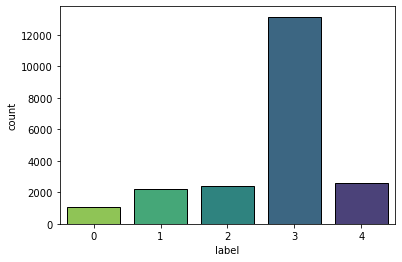

In [7]:
sns.countplot(train.label, edgecolor = 'black',
              palette = reversed(sns.color_palette("viridis", 5)))
plt.show()

In [8]:
grouped = train.groupby(train['label'])

In [9]:
grouped.describe()

label                                   
         count mean  std  min  25%  50%  75%  max
label                                            
0       1087.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1       2189.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0
2       2386.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
3      13158.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0
4       2577.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0

* class 3에 속하는 데이터가 월등히 많은거로 보아, class 간의 불균형이 심한 것을 알 수 있다. 왜곡된 결과를 만들 수 있기 때문에 Image augmentation을 통해 균형을 맞춰줘야 한다.

### CBB(Cassava Bacterial Blight) photos (0)

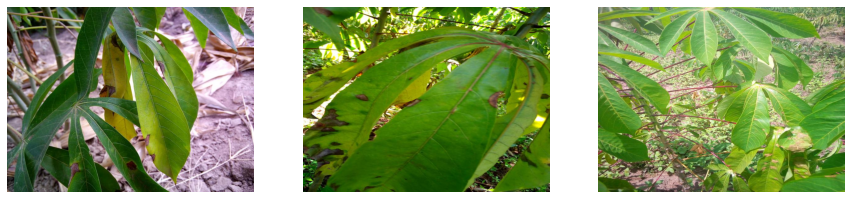

In [10]:
sample = train[train.label == 0].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

### CBSD(Cassava Brown Streak Disease) photos (1)

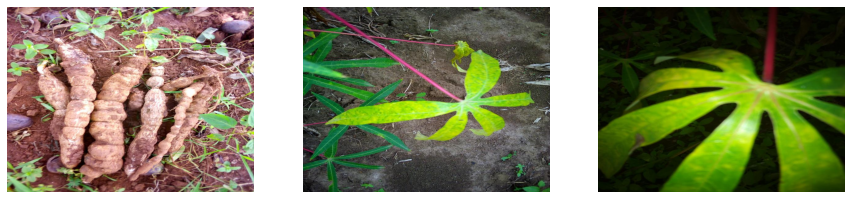

In [11]:
sample = train[train.label == 1].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

### CGM(Cassava Green Mottle) photos (2)

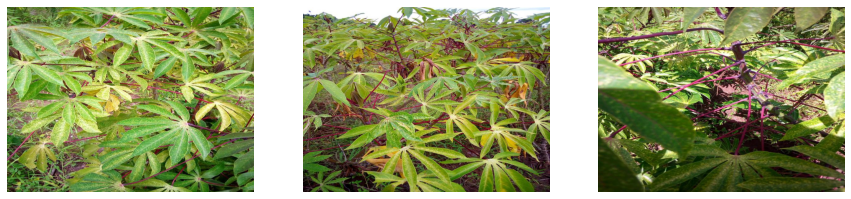

In [12]:
sample = train[train.label == 2].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

### CMD(Cassava Mosaic Disease) photos (3)

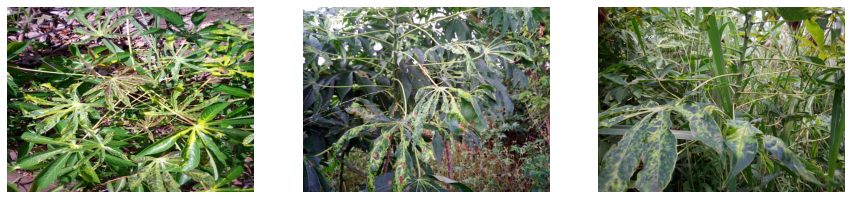

In [13]:
sample = train[train.label == 3].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

### Healty photos (4)

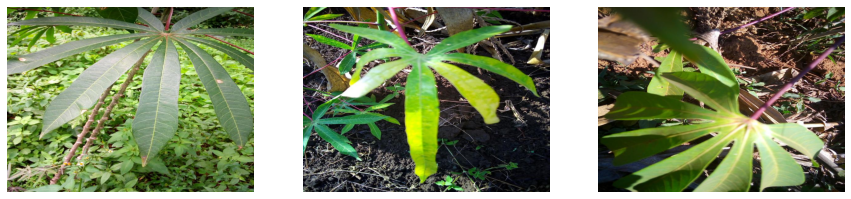

In [14]:
sample = train[train.label == 4].sample(3)
plt.figure(figsize=(15, 5))
for ind, (image_id, label) in enumerate(zip(sample.image_id, sample.label)):
    plt.subplot(1, 3, ind + 1)
    img = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis("off")
    
plt.show()

In [15]:
BATCH_SIZE = 8
STEPS_PER_EPOCH = len(train)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train)*0.2 / BATCH_SIZE
EPOCHS = 20
TARGET_SIZE = 350

### Image augmetation

In [16]:
train.label = train.label.astype('str')

# augmentation
train_datagen = ImageDataGenerator(validation_split = 0.2,
                                    preprocessing_function = None,
                                    rotation_range = 45,
                                    zoom_range = 0.3,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    fill_mode = 'nearest',
                                    shear_range = 0.1,
                                    height_shift_range = 0.1,
                                    width_shift_range = 0.1,
                                    featurewise_center = True,
                                    featurewise_std_normalization = True)

train_generator = train_datagen.flow_from_dataframe(train,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "training",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")


validation_datagen = ImageDataGenerator(validation_split = 0.2)

validation_generator = validation_datagen.flow_from_dataframe(train,
                         directory = os.path.join(BASE_DIR, "train_images"),
                         subset = "validation",
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


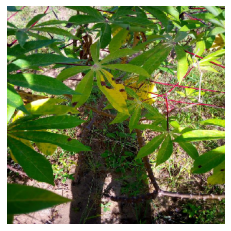

In [17]:
img_path = os.path.join(BASE_DIR, "train_images", train.image_id[0])
img = image.load_img(img_path, target_size = (TARGET_SIZE, TARGET_SIZE))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

Found 1 validated image filenames belonging to 1 classes.


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


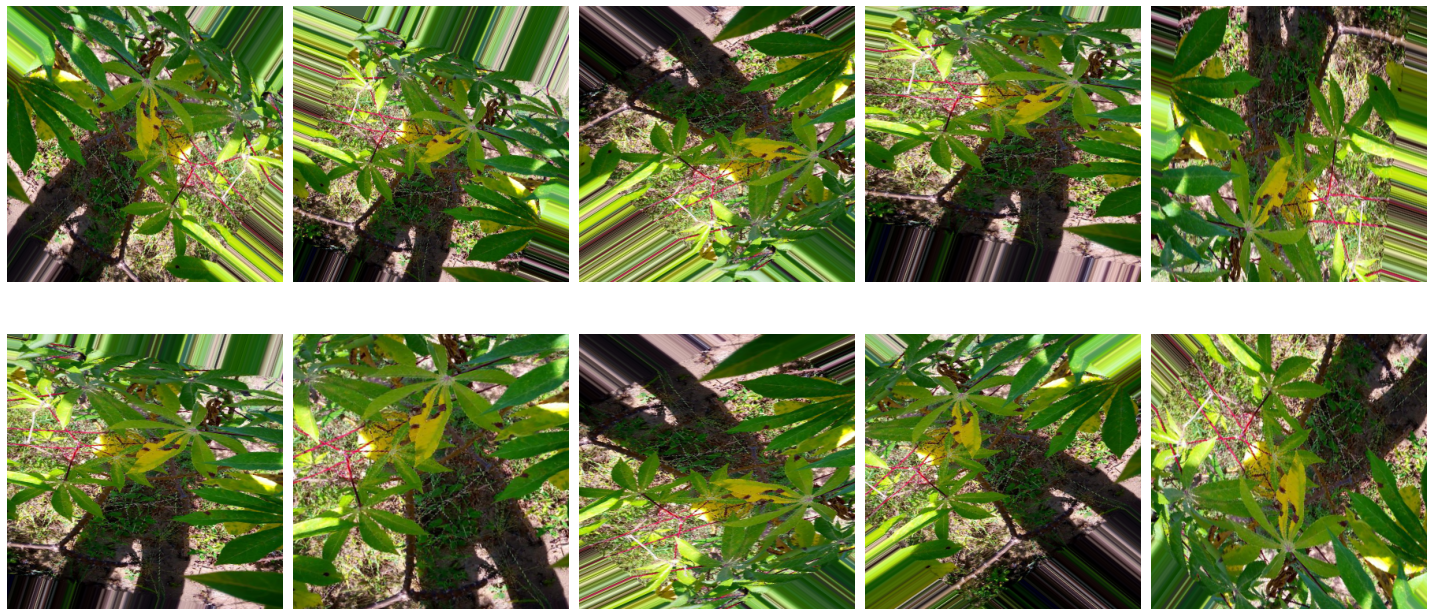

In [18]:
generator = train_datagen.flow_from_dataframe(train.iloc[0:1],
                         directory = os.path.join(BASE_DIR, "train_images"),
                         x_col = "image_id",
                         y_col = "label",
                         target_size = (TARGET_SIZE, TARGET_SIZE),
                         batch_size = BATCH_SIZE,
                         class_mode = "sparse")

aug_images = [generator[0][0][0]/255 for i in range(10)]
fig, axes = plt.subplots(2, 5, figsize = (20, 10))
axes = axes.flatten()
for img, ax in zip(aug_images, axes):
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()
plt.show()

### Modeling

* 상대적으로 성능이 좋은 Efficientnet을 사용하여 전이학습 진행
* EfficientNet: 기존의 성능이 좋은 모델(여기서는 Image net)을 기반으로, 적절한 width, depth, resolution값을 grid search를 통해 얻어낸다
* Imagenet은 개와 고양이를 분류한 모델이다. cassava 데이터셋과 비교했을 때 데이터셋 간의 유사성은 높지 않다고 볼 수 있다. 하지만 이미지 데이터 개수가 20000개 가량으로 큰 편에 속하기 때문에 아예 처음 시작하는 것보다 사전 학습 모델인 Imagenet의 구조와 파라미터들을 가지고 시작해도 될 것이라 판단된다. 
* Classifier는 GAP(Global average pooling)을 사용한다. (FC layer, GAP, SVM)

In [19]:
import keras

model = models.Sequential()
model.add(EfficientNetB0(include_top=False, weights='imagenet',
                        backend = keras.backend,
                        layers = keras.layers,
                        models = keras.models,
                        utils = keras.utils,
         input_shape = (TARGET_SIZE,TARGET_SIZE, 3)))
# imagenet 기반의 efficientnet 추가
# backend, layers, models, utils는 호환성 문제 때문에 코드 수정
model.add(layers.GlobalAveragePooling2D())
# GAP를 통한 pooling, overfitting 방지, 연산량 감소
model.add(layers.Dense(5, activation = 'softmax'))
# 최종 featuremap을 input으로 fclayer를 생성하여 효율적인 학습
model.compile(optimizer = Adam(lr = 0.001),
             loss = 'sparse_categorical_crossentropy',
             metrics = ['acc'])
# 학습 방식 설정

model.summary()

16809984/16804768 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 11, 11, 1280)      4049564   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 4,055,969
Trainable params: 4,013,953
Non-trainable params: 42,016
_________________________________________________________________


In [20]:
model_save = ModelCheckpoint('./best_baseline_model.h5', 
                             save_best_only = True, 
                             save_weights_only = True,
                             monitor = 'val_loss', 
                             mode = 'min', verbose = 1)
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, 
                              patience = 2, min_delta = 0.001, 
                              mode = 'min', verbose = 1)


history = model.fit_generator(
    train_generator,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs = EPOCHS,
    validation_data = validation_generator,
    validation_steps = VALIDATION_STEPS,
    callbacks = [model_save, early_stop, reduce_lr]
)

Epoch 1/20
2140/2139 [==============================] - ETA: 0s - loss: 0.7077 - acc: 0.7515
Epoch 00001: val_loss improved from inf to 0.64923, saving model to ./best_baseline_model.h5
2140/2139 [==============================] - 913s 426ms/step - loss: 0.7077 - acc: 0.7515 - val_loss: 0.6492 - val_acc: 0.7878 - lr: 0.0010
Epoch 2/20
2140/2139 [==============================] - ETA: 0s - loss: 0.5833 - acc: 0.7987
Epoch 00002: val_loss improved from 0.64923 to 0.48573, saving model to ./best_baseline_model.h5
2140/2139 [==============================] - 829s 387ms/step - loss: 0.5833 - acc: 0.7987 - val_loss: 0.4857 - val_acc: 0.8331 - lr: 0.0010
Epoch 3/20
2140/2139 [==============================] - ETA: 0s - loss: 0.5367 - acc: 0.8171
Epoch 00003: val_loss did not improve from 0.48573
2140/2139 [==============================] - 846s 395ms/step - loss: 0.5367 - acc: 0.8171 - val_loss: 0.5285 - val_acc: 0.8236 - lr: 0.0010
Epoch 4/20
2140/2139 [==============================] - ETA:

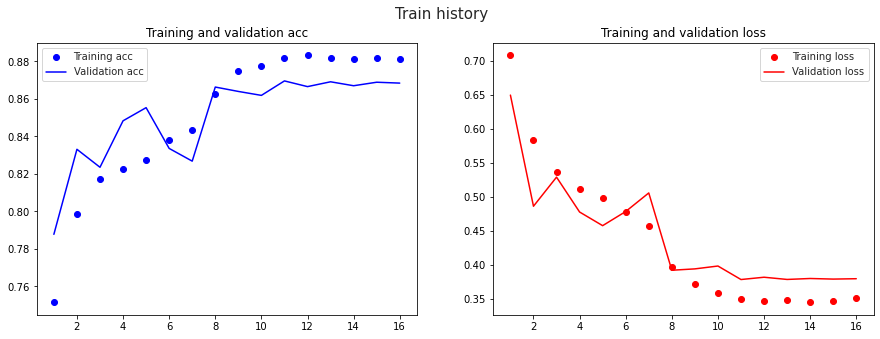

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.set_style("white")
plt.suptitle('Train history', size = 15)

ax1.plot(epochs, acc, "bo", label = "Training acc")
ax1.plot(epochs, val_acc, "b", label = "Validation acc")
ax1.set_title("Training and validation acc")
ax1.legend()

ax2.plot(epochs, loss, "bo", label = "Training loss", color = 'red')
ax2.plot(epochs, val_loss, "b", label = "Validation loss", color = 'red')
ax2.set_title("Training and validation loss")
ax2.legend()

plt.show()

In [22]:
model.save('./baseline_model.h5')

### Predict

In [23]:
submission = pd.read_csv(os.path.join(BASE_DIR,'sample_submission.csv'))
submission

image_id  label
0  2216849948.jpg      4

In [24]:
preds = []

for image_id in submission.image_id:
    image = Image.open(os.path.join(BASE_DIR,  "test_images", image_id))
    image = image.resize((TARGET_SIZE, TARGET_SIZE))
    image = np.expand_dims(image, axis = 0)
    preds.append(np.argmax(model.predict(image)))

submission['label'] = preds
submission

image_id  label
0  2216849948.jpg      4

In [25]:
submission.to_csv('submission.csv', index=False)